In [1]:
import pandas as pd
import numpy as np
import json
import re
import nltk
from nltk.util import ngrams
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
citation_context = pd.read_json("for_india/contexts_ref_gt_100.json")

In [3]:
top666_metadata = pd.read_csv("for_india/metadata_references_gt_100.csv")

In [4]:
top666_metadata['authors'] = top666_metadata.authors.fillna("[]").apply(lambda x:json.loads(x))

In [5]:
def extract_names(name_list):
    names = []
    for name in name_list:
        last_name = name.get("surname")
        if last_name:
            names.append(last_name)
    return names
top666_metadata['authors_LN']=top666_metadata.authors.apply(extract_names)

In [6]:
citation_context = citation_context.set_index("ref_pmid").join(top666_metadata.set_index('pubmed'))

In [7]:
citation_context['ref_pmid'] = citation_context.index

In [8]:
citation_context = citation_context.reset_index()

In [9]:
def match_authors(data):
    matched_names = []
    first_match = 0
    if(data.authors_LN is not None):
        for nr, name in enumerate(data.authors_LN):
            words = set(nltk.word_tokenize(data.sentence))
            if name in words:
                matched_names.append(name)
                first_match = nr + 1
                break
    return first_match
citation_context['matched_names'] = citation_context[['sentence', 'authors_LN']].apply(match_authors, axis=1)

In [312]:
pd.set_option('max_colWidth', 400)

In [428]:
top666_metadata[top666_metadata['pubmed']==388439]

,pubmed,article_title,year,authors,volume,issue,fpage,lpage,page_range,authors_LN
0,388439,Electrophoretic transfer of proteins from polyacrylamide gels to nitrocellulose sheets: procedure and some applications.,1979,"[{'given-names': 'H', 'surname': 'Towbin'}, {'given-names': 'T', 'surname': 'Staehelin'}, {'given-names': 'J', 'surname': 'Gordon'}]",76,9.0,4350,4354.0,NaN,"[Towbin, Staehelin, Gordon]"


In [431]:
citation_context[citation_context['matched_names']==1][0:1]

,index,doi,filename,paragraph_nr,ref_concrete,references,relative_position,section_nr,section_title,sentence,...,authors,volume,issue,fpage,lpage,page_range,authors_LN,ref_pmid,matched_names,abbreviation
0,388439,10.1371/journal.pone.0009736,PMC2840024.nxml,0,pone.0009736-Towbin1,[pone.0009736-Towbin1],0.699301,3,Materials and Methods,Western blot analysis was performed under the conditions described by Towbin [36].,...,"[{'given-names': 'H', 'surname': 'Towbin'}, {'given-names': 'T', 'surname': 'Staehelin'}, {'given-names': 'J', 'surname': 'Gordon'}]",76,9.0,4350,4354.0,NaN,"[Towbin, Staehelin, Gordon]",388439,1,[]


In [403]:
top66LN = pd.DataFrame({"ref_pmid":[],"Count":[],"Normalize":[]})
for index in range(0,len(top666_metadata)):
    indices = citation_context.index[citation_context['ref_pmid']==top666_metadata['pubmed'][index]].tolist()
    count = 0
    #print("TOP PAPER: "+str(len(indices)))
    for ind in indices:
        if citation_context['matched_names'][ind]==1:
            count+=1
    #print("TOP PAPER WITH MENTIONED: "+str(count))
    percentage = count*100.0/len(indices) if count>0 else 0
    top66LN = top66LN.append({"ref_pmid":top666_metadata['pubmed'][index],"Count":count,"Normalize":round(percentage,5)},ignore_index="True")

In [408]:
top66LN = top66LN.sort_values(by=['Normalize'],ascending=False)

In [409]:
top66LN.index = range(1,len(top66LN)+1)

In [410]:
top66LN.index.name = "index"

In [430]:
top66LN[400:410]

,ref_pmid,Count,Normalize
index,,,
401,14597658.0,1.0,0.23202
402,11752295.0,1.0,0.22272
403,19325852.0,1.0,0.21142
404,21565059.0,1.0,0.18149
405,9254694.0,3.0,0.18040
406,2231712.0,3.0,0.17953
407,19505943.0,1.0,0.12804
408,7984417.0,1.0,0.10627
409,21296855.0,1.0,0.10091


<Figure size 1440x720 with 0 Axes>

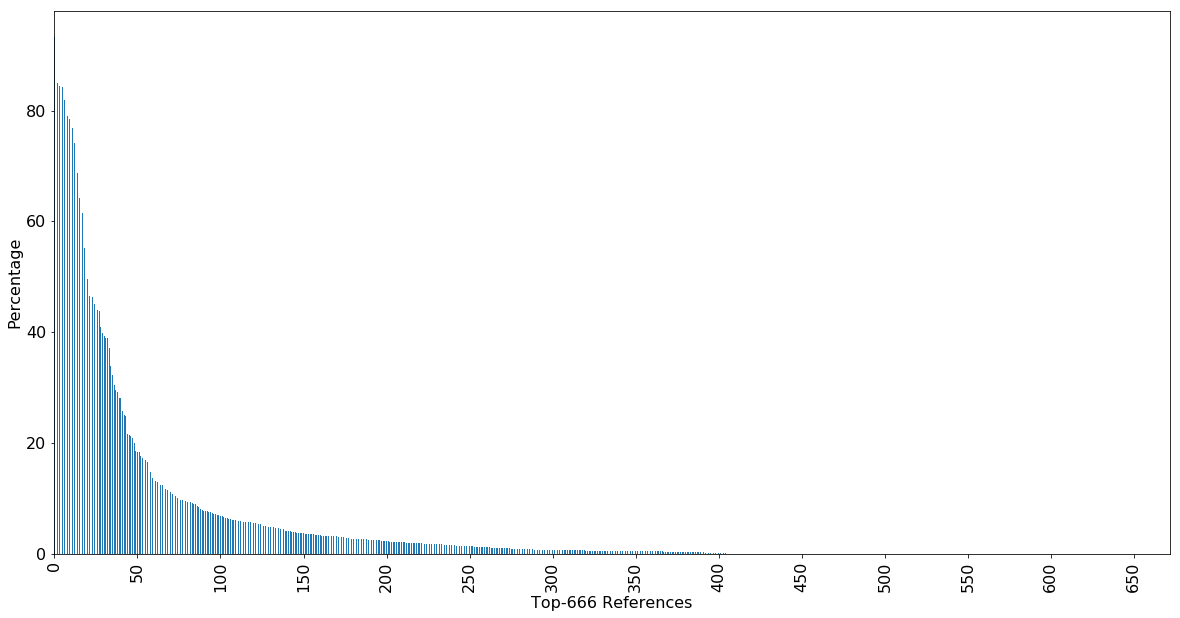

<Figure size 432x288 with 0 Axes>

In [411]:
plt.rcParams.update({'font.size': 16})
plt.figure(figsize=(20,10))
forPlot = top66LN
forPlot[['Normalize']].plot(figsize=(20,10),legend=None,kind='bar')
#forPlot[['ref_pmid','Normalize']].plot.scatter(x='ref_pmid',y='Normalize'
#sortedABB.set_index(sortedABB['Abb']).plot.bar()
#orPlot[0:50].plot.bar()
#plt.title("Author Mentions Percentage found in "+str(len(citation_context))+" citation Context")
plt.xticks(np.arange(0, 670, step=50),labels=[0,50,100,150,200,250,300,350,400,450,500,550,600,650,700])
#plt.xticks(rotation=90)
plt.xlabel("Top-666 References")
plt.ylabel("Percentage")

fig1 = plt.gcf()
plt.show()
plt.draw()
fig1.savefig("BIRNDL/AuthorLNMention1.png",dpi=300,bbox_inches = 'tight')

In [414]:
top66IMRaD = pd.DataFrame({"ref_pmid":[],"Introduction":[],"Discussion":[],"Results":[],"Methods":[]})
for index in range(1,len(top66LN)+1):
    #pubmedId = top666_metadata['pubmed'][index]
    pubmedId = top66LN['ref_pmid'][index]
    ind = citation_context.index[citation_context['ref_pmid'] == pubmedId].tolist()
    introduction = 0
    methods = 0
    results = 0
    discussion = 0
    for row_nr in ind:
        section_title = citation_context['section_title'][row_nr]
        authors_LN = citation_context['authors_LN'][row_nr]
        if(section_title is not None and  authors_LN is not None and citation_context['matched_names'][row_nr]==1):
            introduction+= 1 if("introduction" in section_title.lower()) else 0
            methods+= 1 if("method" in section_title.lower()) else 0
            results= (results+1) if("result" in section_title.lower()) else 0
            discussion+= 1 if("discussion" in section_title.lower()) else 0
    totalCount = (introduction+methods+results+discussion)*1.0
    introduction_perc = introduction*1.0/totalCount if introduction>0 else 0
    methods_perc = methods*1.0/totalCount if methods>0 else 0
    results_perc = results*1.0/totalCount if results>0 else 0
    discussion_perc = discussion*1.0/totalCount if discussion>0 else 0
    
    top66IMRaD = top66IMRaD.append({"ref_pmid":pubmedId,"Introduction":introduction_perc,"Discussion":discussion_perc,"Results":results_perc,"Methods":methods_perc},ignore_index="True")

In [415]:
top66IMRaD['sum']=top66IMRaD["Introduction"]+top66IMRaD["Discussion"]+top66IMRaD["Results"]+top66IMRaD["Methods"]

In [416]:
top66IMRaD[top66IMRaD['sum']>1.0]

,ref_pmid,Introduction,Discussion,Results,Methods,sum


<Figure size 1440x720 with 0 Axes>

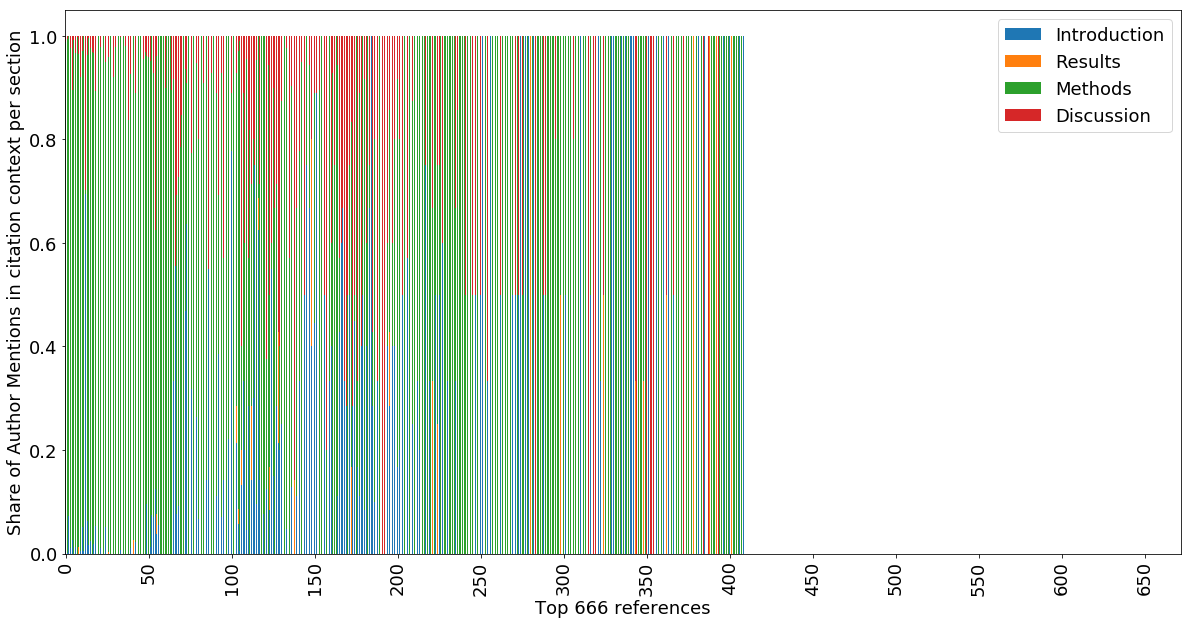

<Figure size 432x288 with 0 Axes>

In [417]:
plt.rcParams.update({'font.size': 18})
plt.figure(figsize=(20,10))
#top66IMRaD.plot(kind='bar', stacked=True)
forPlot = top66IMRaD[['Introduction','Results','Methods','Discussion']]
forPlot.plot(figsize=(20,10),kind='bar',stacked=True)
#sortedABB.set_index(sortedABB['Abb']).plot.bar()
#orPlot[0:50].plot.bar()
#plt.title("Author Mentions IMRaD Percentage found in "+str(len(citation_context))+" citation Context")
#plt.xticks(rotation=90)
plt.xticks(np.arange(0, 670, step=50),labels=[0,50,100,150,200,250,300,350,400,450,500,550,600,650,700])
plt.xlabel("Top 666 references")
plt.ylabel("Share of Author Mentions in citation context per section")


fig1 = plt.gcf()
plt.show()
plt.draw()

fig1.savefig("BIRNDL/AuthorLNMentionIMRaD.png",dpi=300)

## Finding Frequent Pattern

In [621]:
stop_words = set(stopwords.words('english')) 
def generateNgrams(text,n,s=2):
    text = text.lower().replace("("," ").replace(")"," ").replace(","," ").replace("["," ").replace("]"," ").replace(",","").replace("'s"," ").replace("'s"," ").replace("s'"," ").replace("'"," ").replace(". "," ").replace(" '","").replace("' ","").replace("’ "," ").replace(" ’ "," ")
    #text = re.sub(r'[^a-zA-Z0-9\s]', ' ', text)
    text_pos = nltk.pos_tag(nltk.word_tokenize(text.strip().rstrip()))
    text_with_pos = ""
    for index1 in range(0,len(text_pos)):
                        text_with_pos += text_pos[index1][0]+"_"+text_pos[index1][1]+" "
    text_pos = text_with_pos
    #print(text_pos)
    tokens = [token for token in text_pos.split(" ") if token != ""]
    tokens = [w for w in tokens if not w.split("_")[0] in stop_words] 
    output = []
    for num in range(s,n+1):
        output = output + [" ".join(gram) for gram in ngrams(tokens,num)]
    return output
example_sent = "This is a sample sentence, showing off the stop words filtration method). Egers's test Egger ’ test"
generateNgrams(example_sent,n=2)

IndexError: string index out of range

In [507]:
def extractingVERBS(citation_context):
    term = pd.DataFrame({"Term":[],"Frequency":[],"doc":[],"documentFrequency":[]})
    for index in range(0,len(citation_context)):
        if(citation_context['authors_LN'][index] is not None and citation_context['matched_names'][index]==1):
            pubmedId = citation_context['ref_pmid'][index]
            grams = generateNgrams(citation_context['sentence'][index],n=2)
            author_name = citation_context['authors_LN'][index][0]
            #print("AUthor Name: "+author_name)
            for gram in grams:
                words = gram.strip().split(" ")
                cond_1 = words[0].split("_")[0]==author_name.lower() and "VB" in words[1].split("_")[1] and len(words[1])>6
                cond_2 = words[1].split("_")[0]==author_name.lower() and "VB" in words[0].split("_")[1] and len(words[0])>6
                if(cond_1):
                    ind = term.index[term['Term']==words[1]].tolist()
                    if(len(ind)>0):
                        term.at[ind[0], 'Frequency']=term.at[ind[0], 'Frequency']+1
                        if(str(pubmedId) not in term.at[ind[0],'doc'].split(":")):
                            term.at[ind[0],'doc']=term.at[ind[0],'doc']+":"+str(pubmedId)
                            term.at[ind[0],'documentFrequency'] = term.at[ind[0],'documentFrequency']+1
                    else:
                        term = term.append({"Term":words[1],"Frequency":1,"doc":str(pubmedId),"documentFrequency":1},ignore_index=True)
                if(cond_2):
                    ind = term.index[term['Term']==words[0]].tolist()
                    if(len(ind)>0):
                        term.at[ind[0], 'Frequency']=term.at[ind[0], 'Frequency']+1
                        if(str(pubmedId) not in term.at[ind[0],'doc'].split(":")):
                            term.at[ind[0],'doc']=term.at[ind[0],'doc']+":"+str(pubmedId)
                            term.at[ind[0],'documentFrequency'] = term.at[ind[0],'documentFrequency']+1
                    else:
                        term = term.append({"Term":words[0],"Frequency":1,"doc":str(pubmedId),"documentFrequency":1},ignore_index=True)
    return term

In [508]:
Verbs = extractingVERBS(citation_context)

/Users/rajeshpiryani/anaconda3/lib/python3.7/site-packages/pandas/core/ops.py:1649: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)


In [512]:
sortedVerbs = Verbs.sort_values(by=['documentFrequency'], ascending=False)

<Figure size 1440x720 with 0 Axes>

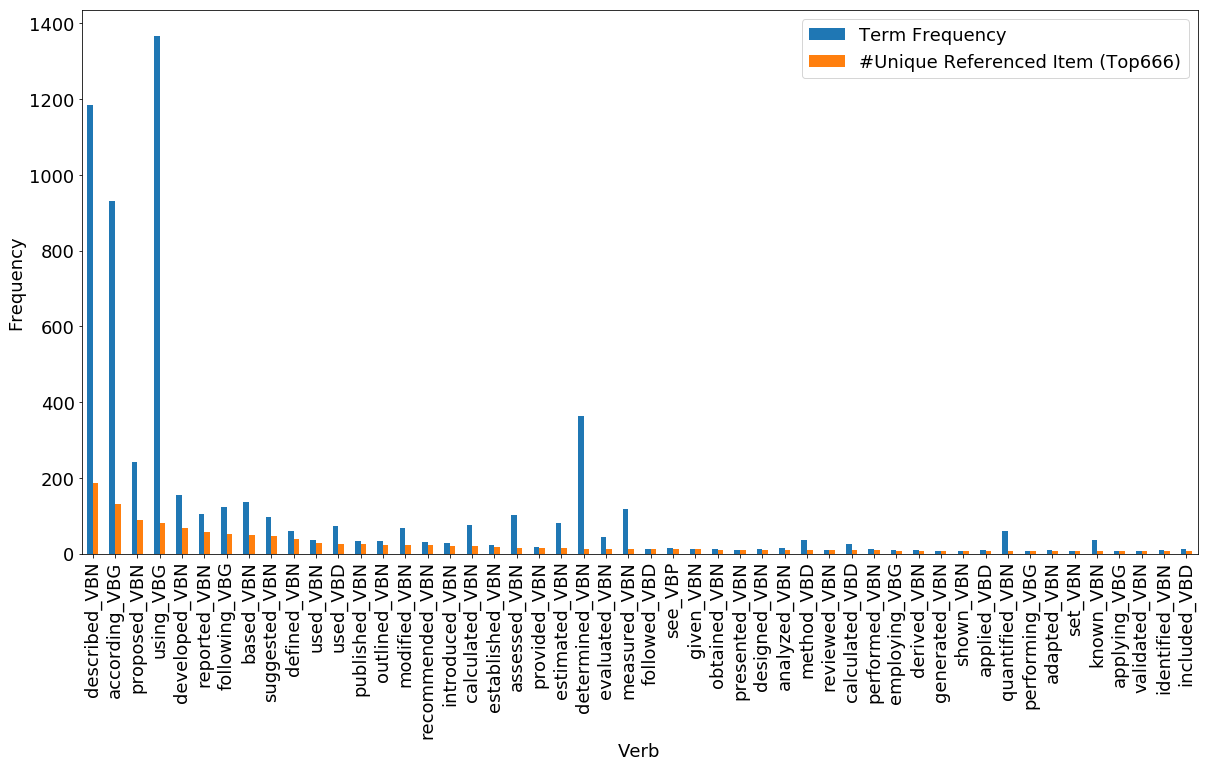

<Figure size 432x288 with 0 Axes>

In [532]:
plt.rcParams.update({'font.size': 18})
plt.figure(figsize=(20,10))
forPlot = sortedVerbs[0:50]
forPlot.set_index(forPlot['Term']).plot.bar(figsize=(20,10))
#sortedABB.set_index(sortedABB['Abb']).plot.bar()
#orPlot[0:50].plot.bar()
plt.xticks(rotation=90)
plt.xlabel("Verb")
plt.ylabel("Frequency")
plt.gca().legend(("Term Frequency","#Unique Referenced Item (Top666)"))
fig1 = plt.gcf()
plt.show()
plt.draw()
fig1.savefig("BIRNDL/BiGramFrequentVERB.png",bbox_inches = 'tight')

In [514]:
def extractingNOUNS(citation_context):
    term = pd.DataFrame({"Term":[],"Frequency":[],"doc":[],"documentFrequency":[]})
    for index in range(0,len(citation_context)):
        if(citation_context['authors_LN'][index] is not None and citation_context['matched_names'][index]==1):
            pubmedId = citation_context['ref_pmid'][index]
            grams = generateNgrams(citation_context['sentence'][index],n=2)
            author_name = citation_context['authors_LN'][index][0]
            #print("AUthor Name: "+author_name)
            for gram in grams:
                words = gram.strip().split(" ")
                cond_1 = words[0].split("_")[0]==author_name.lower() and "NN" in words[1].split("_")[1] and "NNS" not in words[1].split("_")[1] and len(words[1])>6
                cond_2 = words[1].split("_")[0]==author_name.lower() and "NN" in words[0].split("_")[1] and "NNS" not in words[0].split("_")[1]and len(words[0])>6
                if(cond_1):
                    ind = term.index[term['Term']==words[1]].tolist()
                    if(len(ind)>0):
                        term.at[ind[0], 'Frequency']=term.at[ind[0], 'Frequency']+1
                        if(str(pubmedId) not in term.at[ind[0],'doc'].split(":")):
                            term.at[ind[0],'doc']=term.at[ind[0],'doc']+":"+str(pubmedId)
                            term.at[ind[0],'documentFrequency'] = term.at[ind[0],'documentFrequency']+1
                    else:
                        term = term.append({"Term":words[1],"Frequency":1,"doc":str(pubmedId),"documentFrequency":1},ignore_index=True)
                if(cond_2):
                    ind = term.index[term['Term']==words[0]].tolist()
                    if(len(ind)>0):
                        term.at[ind[0], 'Frequency']=term.at[ind[0], 'Frequency']+1
                        if(str(pubmedId) not in term.at[ind[0],'doc'].split(":")):
                            term.at[ind[0],'doc']=term.at[ind[0],'doc']+":"+str(pubmedId)
                            term.at[ind[0],'documentFrequency'] = term.at[ind[0],'documentFrequency']+1
                    else:
                        term = term.append({"Term":words[0],"Frequency":1,"doc":str(pubmedId),"documentFrequency":1},ignore_index=True)
    return term

In [516]:
Nouns = extractingNOUNS(citation_context)

/Users/rajeshpiryani/anaconda3/lib/python3.7/site-packages/pandas/core/ops.py:1649: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)


In [517]:
sortedNouns = Nouns.sort_values(by=['documentFrequency'], ascending=False)

<Figure size 1440x720 with 0 Axes>

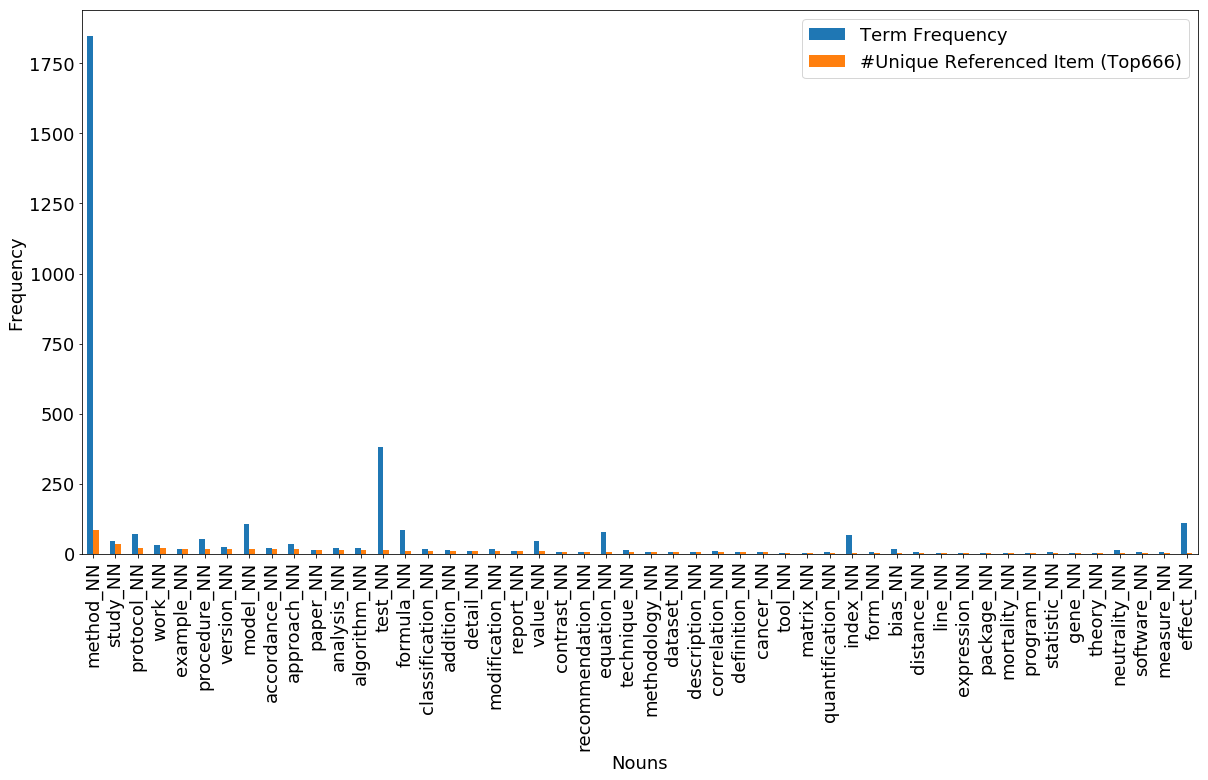

<Figure size 432x288 with 0 Axes>

In [518]:
plt.rcParams.update({'font.size': 18})
plt.figure(figsize=(20,10))
forPlot = sortedNouns[0:50]
forPlot.set_index(forPlot['Term']).plot.bar(figsize=(20,10))
#sortedABB.set_index(sortedABB['Abb']).plot.bar()
#orPlot[0:50].plot.bar()
plt.xticks(rotation=90)
plt.xlabel("Nouns")
plt.ylabel("Frequency")
plt.gca().legend(("Term Frequency","#Unique Referenced Item (Top666)"))
fig1 = plt.gcf()
plt.show()
plt.draw()
fig1.savefig("BIRNDL/BiGramFrequentNouns.png",bbox_inches = 'tight')

In [280]:
SelectedVerbsNouns = sortedVerbs[0:15].Term.apply(lambda x:x.split("_")[0]).tolist()+sortedNouns[0:15].Term.apply(lambda x:x.split("_")[0]).tolist()

In [568]:
def extractingMethods(citation_context):
    term = pd.DataFrame({"Term":[],"Frequency":[]})
    for index in range(0,len(citation_context)):
        if(citation_context['authors_LN'][index] is not None and citation_context['matched_names'][index]==1):
            grams = generateNgrams(citation_context['sentence'][index],n=3,s=3)
            for gram in grams:
                #print(gram)
                new_gram = ""
                for g in gram.split(" "):
                    new_gram+=g.split("_")[0]+" "
                gram = new_gram.strip().replace(" ’ "," ").replace(" ’","")
                gram = gram.strip().rstrip()
                if(len(gram.split(" "))==3):
                #print(gram+"_NEW")
                    if(citation_context['authors_LN'][index][0].lower() in gram):
                        LN = citation_context['authors_LN'][index][0]
                        gram = gram.replace(LN.lower(),LN)
                        for word in gram.split(" "):
                            if word in SelectedVerbsNouns:
                                ind = term.index[term['Term']==gram].tolist()
                                if(len(ind)>0):
                                    term.at[ind[0], 'Frequency']=term.at[ind[0], 'Frequency']+1
                                    #print("FILE: "+citation_context['filename'][index]+"\tREF_PEB_ID: "+str(citation_context['ref_pmid'][index])+":\t"+citation_context['sentence'][index])
                                else:
                                    term = term.append({"Term":gram,"Frequency":1},ignore_index=True)    
    return term

In [558]:
%time
Methods = extractingMethods(citation_context)

CPU times: user 5 µs, sys: 1e+03 ns, total: 6 µs
Wall time: 11.9 µs


/Users/rajeshpiryani/anaconda3/lib/python3.7/site-packages/pandas/core/ops.py:1649: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)


In [559]:
sortedMethods = Methods.sort_values(by=['Frequency'], ascending=False)
sortedMethods.to_excel("MethodsInAuthorMentionsTrigram.xlsx")

<Figure size 1440x720 with 0 Axes>

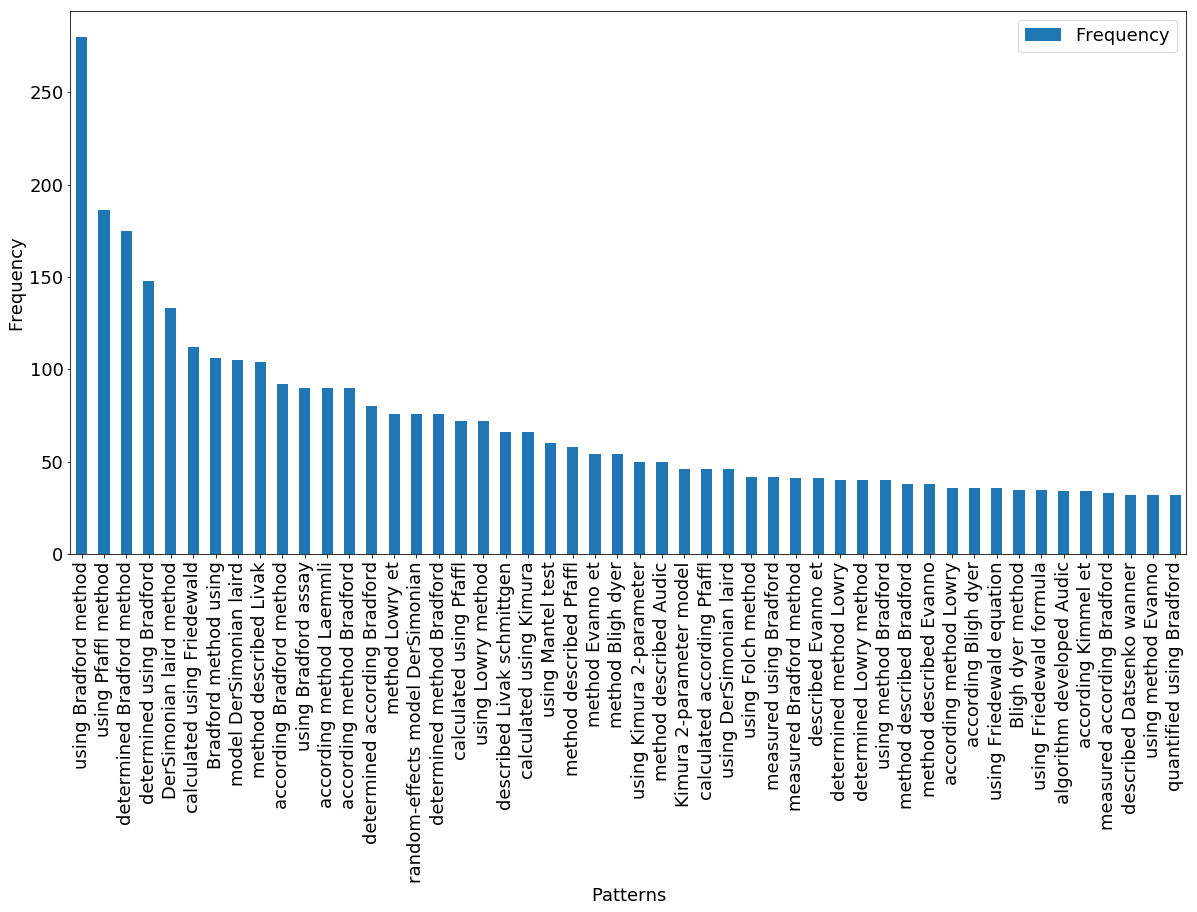

<Figure size 432x288 with 0 Axes>

In [562]:
plt.rcParams.update({'font.size': 18})
plt.figure(figsize=(20,10))
forPlot = sortedMethods[0:50]
forPlot.set_index(forPlot['Term']).plot.bar(figsize=(20,10))
#sortedABB.set_index(sortedABB['Abb']).plot.bar()
#orPlot[0:50].plot.bar()
#plt.title("Metods Found with Top 10 Frequent Verbs and Selected Handy Nouns")
plt.xticks(rotation=90)
plt.xlabel("Patterns")
plt.ylabel("Frequency")
fig1 = plt.gcf()
plt.show()
plt.draw()
fig1.savefig("BIRNDL/MethodsInAuthorMentionsTrigram.png",bbox_inches = 'tight')

## EXtracting Abbreviation

In [650]:
citation_context= citation_context.reset_index()

In [651]:
def extract_abbreviation(citation_context):
    pattern = "[^\s]+[A-Z][^\s,)(]*"
    #pattern = "(([a-z0-9]*[-A-Z]){2,10}[\wa-z0-9]*)"
    all_match = re.findall(pattern, citation_context)
    return all_match
citation_context['abbreviation']=citation_context.sentence.apply(extract_abbreviation)

In [675]:
def match_abbreviation(data):
    matched_abb = []
    title = top666_metadata[top666_metadata['pubmed']==data.ref_pmid]['article_title'].tolist()
    if(len(data.abbreviation)>0):
        for nr, name in enumerate(data.abbreviation):
            words = set(nltk.word_tokenize(title[0]))
            if name in words:
                matched_abb.append(name)
    return matched_abb

citation_context['matched_abbreviation'] = citation_context[['sentence','abbreviation','ref_pmid']].apply(match_abbreviation, axis=1)

HELLO


In [681]:
def match_abbreviation(data):
    count = 0
    title = top666_metadata[top666_metadata['pubmed']==data.ref_pmid]['article_title'].tolist()
    if(len(data.abbreviation)>0):
        for nr, name in enumerate(data.abbreviation):
            words = set(nltk.word_tokenize(title[0]))
            if name in words:
                count+=1
    return count

citation_context['matched_abbreviation_num'] = citation_context[['sentence', 'abbreviation','ref_pmid']].apply(match_abbreviation, axis=1)

In [630]:
citation_context['abbreviation'][3]

['BmSOD1',
 'BmSOD2',
 'SDS-PAGE',
 'anti-SOD1',
 'BmSOD1',
 'UK',
 'anti-SOD2',
 'BmSOD2',
 'IgG-conjugated',
 '(HRP',
 'CA']

In [682]:
top66LNABB = pd.DataFrame({"ref_pmid":[],"Count":[],"Normalize":[]})
for index in range(0,len(top666_metadata)):
    indices = citation_context.index[citation_context['ref_pmid']==top666_metadata['pubmed'][index]].tolist()
    count = 0
    #print("TOP PAPER: "+str(len(indices)))
    for ind in indices:
        if citation_context['matched_abbreviation_num'][ind]>0:
            count+=1
    #print("TOP PAPER WITH MENTIONED: "+str(count))
    percentage = count*100.0/len(indices) if count>0 else 0
    top66LNABB = top66LNABB.append({"ref_pmid":top666_metadata['pubmed'][index],"Count":count,"Normalize":round(percentage,5)},ignore_index="True")

In [683]:
top66LNABB = top66LNABB.sort_values(by=['Normalize'],ascending=False)

In [684]:
top66LNABB.index = range(1,len(top66LNABB)+1)

In [685]:
top66LNABB.index.name = "index"

<Figure size 1440x720 with 0 Axes>

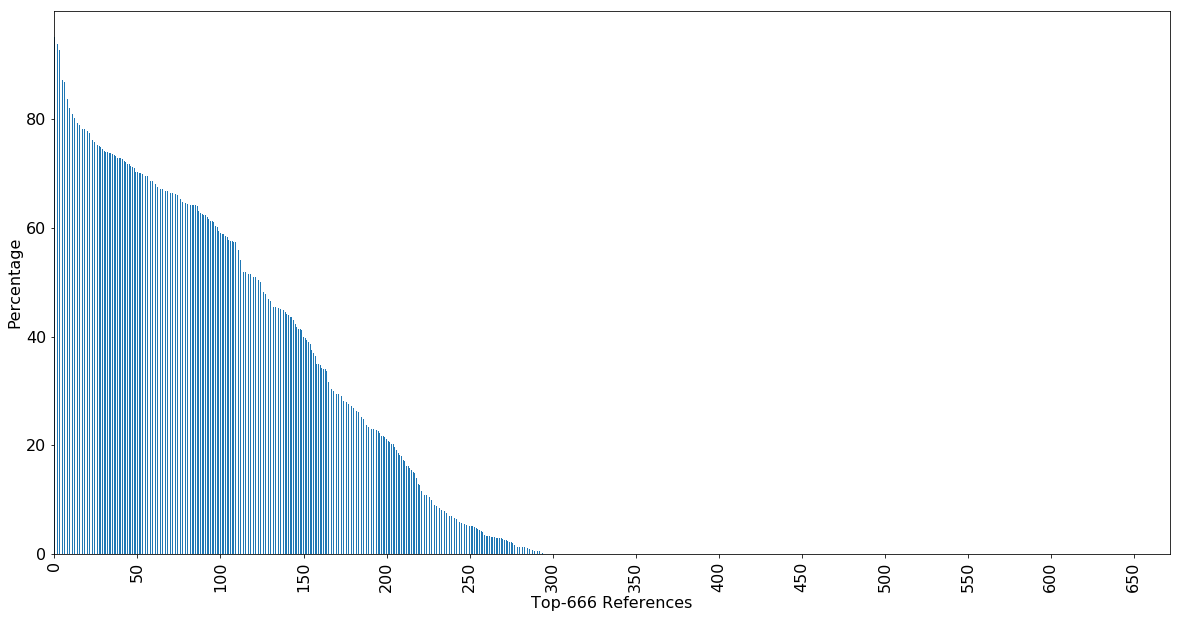

<Figure size 432x288 with 0 Axes>

In [686]:
plt.rcParams.update({'font.size': 16})
plt.figure(figsize=(20,10))
forPlot = top66LNABB
forPlot[['Normalize']].plot(figsize=(20,10),legend=None,kind='bar')
#forPlot[['ref_pmid','Normalize']].plot.scatter(x='ref_pmid',y='Normalize'
#sortedABB.set_index(sortedABB['Abb']).plot.bar()
#orPlot[0:50].plot.bar()
#plt.title("Author Mentions Percentage found in "+str(len(citation_context))+" citation Context")
plt.xticks(np.arange(0, 670, step=50),labels=[0,50,100,150,200,250,300,350,400,450,500,550,600,650,700])
#plt.xticks(rotation=90)
plt.xlabel("Top-666 References")
plt.ylabel("Percentage")

fig1 = plt.gcf()
plt.show()
plt.draw()
fig1.savefig("BIRNDL/ABB_AuthorLNMention.png",dpi=300,bbox_inches = 'tight')

In [687]:
top66IMRaDABB = pd.DataFrame({"ref_pmid":[],"Introduction":[],"Discussion":[],"Results":[],"Methods":[]})
for index in range(1,len(top66LNABB)+1):
    pubmedId = top66LNABB['ref_pmid'][index]
    ind = citation_context.index[citation_context['ref_pmid'] == pubmedId].tolist()
    introduction = 0
    methods = 0
    results = 0
    discussion = 0
    for row_nr in ind:
        section_title = citation_context['section_title'][row_nr]
        if(section_title is not None and citation_context['matched_abbreviation_num'][row_nr]>0):
            introduction+= 1 if("introduction" in section_title.lower()) else 0
            methods+= 1 if("method" in section_title.lower()) else 0
            results= (results+1) if("result" in section_title.lower()) else 0
            discussion+= 1 if("discussion" in section_title.lower()) else 0
    totalCount = (introduction+methods+results+discussion)*1.0
    introduction_perc = introduction*1.0/totalCount if introduction>0 else 0
    methods_perc = methods*1.0/totalCount if methods>0 else 0
    results_perc = results*1.0/totalCount if results>0 else 0
    discussion_perc = discussion*1.0/totalCount if discussion>0 else 0
    
    top66IMRaDABB = top66IMRaDABB.append({"ref_pmid":pubmedId,"Introduction":introduction_perc,"Discussion":discussion_perc,"Results":results_perc,"Methods":methods_perc},ignore_index="True")

In [688]:
top66IMRaDABB['sum']=top66IMRaDABB["Introduction"]+top66IMRaDABB["Discussion"]+top66IMRaDABB["Results"]+top66IMRaDABB["Methods"]

In [689]:
top66IMRaDABB[top66IMRaDABB['sum']>1.0]

,ref_pmid,Introduction,Discussion,Results,Methods,sum


<Figure size 1440x720 with 0 Axes>

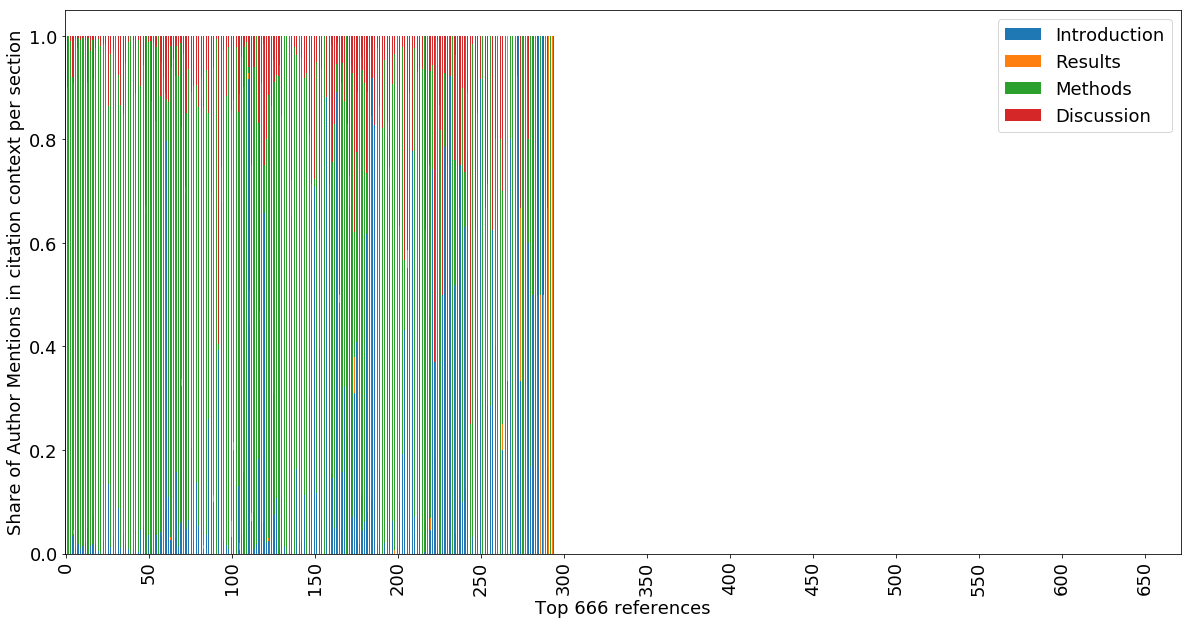

<Figure size 432x288 with 0 Axes>

In [690]:
plt.rcParams.update({'font.size': 18})
plt.figure(figsize=(20,10))
#top66IMRaD.plot(kind='bar', stacked=True)
forPlot = top66IMRaDABB[['Introduction','Results','Methods','Discussion']]
forPlot.plot(figsize=(20,10),kind='bar',stacked=True)
#sortedABB.set_index(sortedABB['Abb']).plot.bar()
#orPlot[0:50].plot.bar()
#plt.title("Author Mentions IMRaD Percentage found in "+str(len(citation_context))+" citation Context")
#plt.xticks(rotation=90)
plt.xticks(np.arange(0, 670, step=50),labels=[0,50,100,150,200,250,300,350,400,450,500,550,600,650,700])
plt.xlabel("Top 666 references")
plt.ylabel("Share of Author Mentions in citation context per section")


fig1 = plt.gcf()
plt.show()
plt.draw()

fig1.savefig("BIRNDL/ABB_AuthorLNMentionIMRaD.png",dpi=300)